In [1]:
from datascience import *
import numpy as np

import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
plots.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
patients = Table.read_table('https://raw.githubusercontent.com/data-8/textbook/main/assets/data/breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


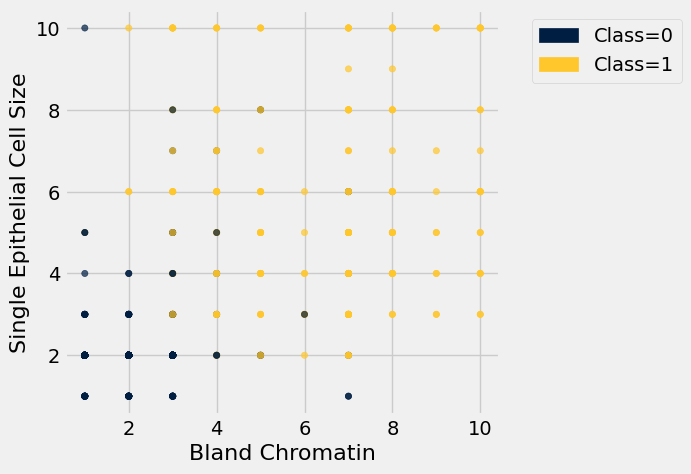

In [3]:
patients.scatter('Bland Chromatin', 'Single Epithelial Cell Size', group='Class')

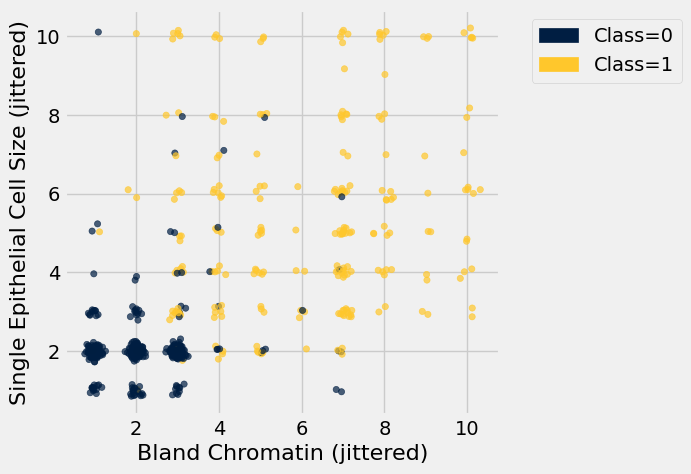

In [4]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))


jittered = Table().with_columns([
    'Bland Chromatin (jittered)',
    randomize_column(patients.column('Bland Chromatin')),
    'Single Epithelial Cell Size (jittered)',
    randomize_column(patients.column('Single Epithelial Cell Size')),
    'Class',
    patients.column('Class')
])

jittered.scatter('Bland Chromatin (jittered)', 'Single Epithelial Cell Size (jittered)', group='Class')

In [ ]:
## Distance

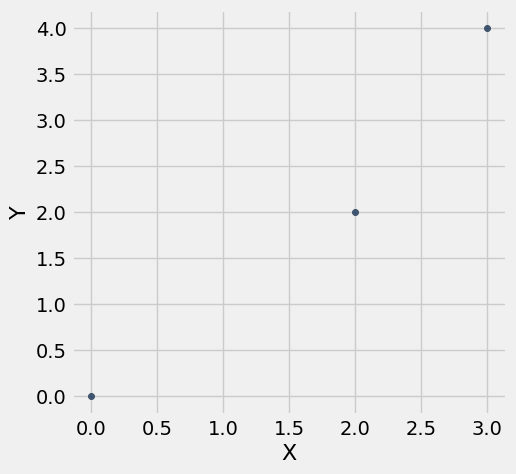

In [5]:
Table().with_columns(['X', [0,2,3], 'Y', [0,2,4]]).scatter('X', 'Y')

In [6]:
def distance(pt1, pt2):
    """Distance between two points (represented as arrays.)"""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """Distance between two rows."""
    return distance(np.array(row1), np.array(row2))

In [7]:
attributes = patients.drop('Class')
attributes.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [8]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [9]:
row_distance(attributes.row(0), attributes.row(2))

2.2360679774997898

In [10]:
row_distance(attributes.row(0), attributes.row(0))

0.0

In [11]:
## Classification Procedure

In [31]:
def distances(training, example):
    """Compute a table with the training set and distances to the example for each row in the training set."""
    dists = []
    attributes = training.drop('Class')
    for row in attributes.rows:
        dist = row_distance(row, example)
        dists.append(dist)
    return training.with_column('Distance', dists)

In [32]:
def closest(training, example, k):
    """Return a table of the k closets neighbors to example."""
    return distances(training, example).sort('Distance').take(np.arange(k))

In [33]:
patients.take(12)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,3,3,3,2,3,4,4,1,1


In [34]:
example = patients.drop('Class').row(12)
example

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

In [35]:
closest(patients, example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,3,2,3,4,4,1,1,0
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662


In [36]:
closest(patients.exclude(12), example, 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662
4,3,3,1,2,1,3,3,1,0,3.31662


In [52]:
def majority_class(neighbors):
    """Return the class that's most common among all these neighbors."""
    return neighbors.group('Class').sort('count', descending=True).column('Class').item(0)

In [53]:
def classify(training, example, k):
    """Return the majority class among the k nearest neighbors."""
    nearest_neighbors = closest(training, example, k)
    return majority_class(nearest_neighbors)

In [54]:
classify(patients.exclude(12), example, 5)

0